# Basics of Thermodynamics

We are going to be studying the basic thermodynamics of 3 types of gas molecules today: H$_2$, O$_2$ and H$_2$O. We have provided the structures for you in files called: `h2.xyz`, `o2.xyz` and `h2o.xyz`. You can read about the functions we are going to be using on the ASE wiki.

On vibrations: https://wiki.fysik.dtu.dk/ase/ase/vibrations/vibrations.html

On thermochemistry: https://wiki.fysik.dtu.dk/ase/ase/thermochemistry/thermochemistry.html

Let's first try and visualize them

In [ ]:
!ase gui o2.xyz  # Change the filename to view the other files

Let's calculate the vibrational frequencies, and other thermodynamic properties. Try to understand what is happening in the script below, and modify which gas is being calculated. Remember the change the filename in the first line, as well as the molecule type.

### Tasks
* Relax geometry
* Calculate vibrational frequencies
* Using the ase gui
    * Look at the relaxation of the atoms
    * Look at the vibrational modes
* Estimate zero point vibrational energy, heat capacity, entropic contributions in different temperatures
    * Hint: Look in the output files from the vibrational calculation logs
* Calculate when thermal dissociation of water into O$_2$ and H$_2$ becomes feasible, e.g. using excel

In [ ]:
%%writefile o2_free_en_gas.py
import numpy as np

from ase.io import read
from ase.thermochemistry import IdealGasThermo
from ase.optimize import BFGS
from ase.visualize import view
from ase.vibrations import Vibrations
from ase.parallel import paropen, parprint

from gpaw import GPAW, FermiDirac

molecule = 'o2'  # Change this depending on gas type, 'h2', 'o2' or 'h2o'

system = read(molecule+'.xyz') # Read the atoms object

# Help GPAW with convergence
if molecule == 'o2':
    system.set_initial_magnetic_moments(magmoms=[0.3, 0.3])

system.center(vacuum=5)  # shouldn't be too small (avoid neighbour interaction)

calc = GPAW(txt=molecule+'.txt',
            xc='PBE', # what is the effect of xc functional
            h=0.2)   # smaller grid leads to more accurate calculation

system.set_calculator(calc)
opt = BFGS(system, trajectory=molecule+'.traj')
opt.run(fmax=0.005) # how well relaxed in terms of forces
calc.write(molecule+'.gpw', 'all')

en = system.get_potential_energy()

parprint('Molecule: {}\tEnergy: {:.3f} eV'.format(molecule, en))

vib = Vibrations(system, name=molecule+'_vib',
                 nfree=2, delta=0.01) # approximation method and displacement
vib.run()
vib_energies = vib.get_energies()

parprint(vib_energies)
vib.summary()

for i in range(3*len(system)): # based on the number of atoms: 3N
    vib.write_mode(i)
    
# Settings for the IdealGasThermo function
thermosettings = {'o2': {'geometry': 'linear', 'spin': 1.0, 'symmetrynumber': 2},
                  'h2': {'geometry': 'linear', 'spin': 0.0, 'symmetrynumber': 2},
                  'h2o': {'geometry': 'nonlinear', 'spin': 0.0, 'symmetrynumber': 2}}

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=en,
                        atoms=system,
                        **thermosettings[molecule]  # The ** is dictionary unpacking
                        )

filename  = molecule + '_free.txt'  # output file name
with paropen(filename, 'w') as fid:
    print('Molecule:', molecule, file=fid)
    for T in np.linspace(200., 6000., 50):
        G = thermo.get_gibbs_energy(temperature=T, pressure=101325.)
        print('Temp: {:.3f} K  \tGibbs Free Energy: {:.4f} eV '.format(T, G), file=fid)

In [ ]:
!qsub.py -p 8 -t 1 o2_free_en_gas.py

In [ ]:
!qstat -u $USER

Read the resulting output files once they are done

In [ ]:
# Adjust the name to the filename you want to read
!cat "$(ls -t o2_free_en_gas.py.e* | head -1)"  # Only read the newest file with the specified name format

In [ ]:
# Read all of the files called something with '_free.txt', i.e. h2_free.txt, o2_free.txt and h2o_free.txt
!tail -n +1 *_free.txt

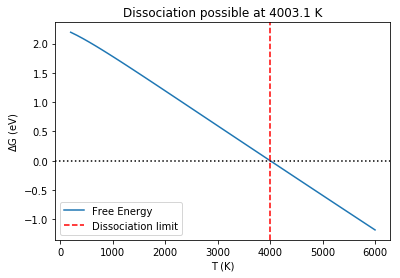

Temp: 200.000 K   	dG: 2.194 eV
Temp: 318.367 K   	dG: 2.141 eV
Temp: 436.735 K   	dG: 2.084 eV
Temp: 555.102 K   	dG: 2.024 eV
Temp: 673.469 K   	dG: 1.961 eV
Temp: 791.837 K   	dG: 1.897 eV
Temp: 910.204 K   	dG: 1.831 eV
Temp: 1028.571 K   	dG: 1.764 eV
Temp: 1146.939 K   	dG: 1.696 eV
Temp: 1265.306 K   	dG: 1.627 eV
Temp: 1383.673 K   	dG: 1.558 eV
Temp: 1502.041 K   	dG: 1.489 eV
Temp: 1620.408 K   	dG: 1.419 eV
Temp: 1738.776 K   	dG: 1.349 eV
Temp: 1857.143 K   	dG: 1.279 eV
Temp: 1975.510 K   	dG: 1.208 eV
Temp: 2093.878 K   	dG: 1.138 eV
Temp: 2212.245 K   	dG: 1.067 eV
Temp: 2330.612 K   	dG: 0.997 eV
Temp: 2448.980 K   	dG: 0.926 eV
Temp: 2567.347 K   	dG: 0.856 eV
Temp: 2685.714 K   	dG: 0.785 eV
Temp: 2804.082 K   	dG: 0.714 eV
Temp: 2922.449 K   	dG: 0.644 eV
Temp: 3040.816 K   	dG: 0.573 eV
Temp: 3159.184 K   	dG: 0.502 eV
Temp: 3277.551 K   	dG: 0.432 eV
Temp: 3395.918 K   	dG: 0.361 eV
Temp: 3514.286 K   	dG: 0.291 eV
Temp: 3632.653 K   	dG: 0.220 eV
Temp: 3751.020 K 

In [12]:
# Teacher
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import root

energies = {}
for gas in ['o2', 'h2', 'h2o']:
    energies[gas] = []
    temp = []
    with open('{}_free.txt'.format(gas), 'r') as f:
        next(f)  # Skip first line
        for line in f:
            data = line.strip().split()
            T = float(data[1])
            E = float(data[6])
            temp.append(T)
            energies[gas].append(E)

# Should see dissociation at roughly 4000 K
x, y = [], []

for ii, T in enumerate(temp):
    e_o2 = energies['o2'][ii]
    e_h2 = energies['h2'][ii]
    e_h2o = energies['h2o'][ii]
    dG = e_h2 + 0.5 * e_o2 - e_h2o
    x.append(T)
    y.append(dG)
    
%matplotlib inline
f = interp1d(x, y)
t0 = (root(f, 4000).x)[0]

plt.plot(x, y, label='Free Energy')

plt.axhline(y=0, color='k', linestyle=':')
plt.axvline(x=t0, color='r', linestyle='--', label='Dissociation limit')

plt.title('Dissociation possible at {:.1f} K'.format(t0))
plt.legend(loc='best')
plt.xlabel('T (K)')
plt.ylabel('$\Delta$G (eV)')
plt.show()

for T, dG in zip(x, y):
    print('Temp: {:.3f} K   \tdG: {:.3f} eV'.format(T, dG))